In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import kruskal,chi2_contingency

In [3]:
marketing_campaign_df= pd.read_csv("D:\DeepLearning\Fast_food\WA_Marketing-Campaign.csv", sep=",", index_col=0)
marketing_campaign_df.head()

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\smrut\AppData\Local\Temp\ipykernel_19300\3323032753.py:1: SyntaxWarning: invalid escape sequence '\D'
  marketing_campaign_df= pd.read_csv("D:\DeepLearning\Fast_food\WA_Marketing-Campaign.csv", sep=",", index_col=0)


,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
MarketID,,,,,,
1,Medium,1,4,3,1,33.73
1,Medium,1,4,3,2,35.67
1,Medium,1,4,3,3,29.03
1,Medium,1,4,3,4,39.25
1,Medium,2,5,2,1,27.81


In [ ]:
print("Dataset Info:")
print(marketing_campaign_df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 548 entries, 1 to 10
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketSize        548 non-null    object 
 1   LocationID        548 non-null    int64  
 2   AgeOfStore        548 non-null    int64  
 3   Promotion         548 non-null    int64  
 4   week              548 non-null    int64  
 5   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(4), object(1)
memory usage: 30.0+ KB
None


In [4]:
# Check for missing values
print("\nMissing Values:")
print(marketing_campaign_df.isnull().sum())

# Count unique values for categorical variables
print("\nUnique Market Sizes:")
print(marketing_campaign_df["MarketSize"].value_counts())

print("\nPromotion Distribution:")
print(marketing_campaign_df["Promotion"].value_counts())


Missing Values:
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64

Unique Market Sizes:
MarketSize
Medium    320
Large     168
Small      60
Name: count, dtype: int64

Promotion Distribution:
Promotion
3    188
2    188
1    172
Name: count, dtype: int64


In [4]:
marketing_campaign_df["Promotion"] = marketing_campaign_df["Promotion"].astype(str)

In [5]:
# Identify and fix inconsistent column names
marketing_campaign_df.columns = marketing_campaign_df.columns.str.strip().str.replace(" ", "_").str.lower()

In [6]:
marketing_campaign_df

,marketsize,locationid,ageofstore,promotion,week,salesinthousands
MarketID,,,,,,
1,Medium,1,4,3,1,33.73
1,Medium,1,4,3,2,35.67
1,Medium,1,4,3,3,29.03
1,Medium,1,4,3,4,39.25
1,Medium,2,5,2,1,27.81
...,...,...,...,...,...,...
10,Large,919,2,1,4,64.34
10,Large,920,14,2,1,50.20
10,Large,920,14,2,2,45.75


In [7]:
# Standardize categorical data
categorical_columns = ["marketsize", "promotion"]
for col in categorical_columns:
    marketing_campaign_df[col] = marketing_campaign_df[col].str.strip().str.lower()

In [8]:
# Display unique values to check consistency
for col in categorical_columns:
    print(f"Unique values in {col}: {marketing_campaign_df[col].unique()}")

Unique values in marketsize: ['medium' 'small' 'large']
Unique values in promotion: ['3' '2' '1']


In [9]:
# Calculate median weekly sales per promotion
df_median_sales = marketing_campaign_df.groupby("promotion")["salesinthousands"].median().reset_index()
print("Median Weekly Sales by Promotion:\n", df_median_sales)

Median Weekly Sales by Promotion:
   promotion  salesinthousands
0         1            55.385
1         2            45.385
2         3            51.165


In [10]:
promotion_counts = marketing_campaign_df["promotion"].value_counts()
total_entries = len(marketing_campaign_df)
promotion_stats = pd.DataFrame(
    {
        "promotion": promotion_counts.index,
        "counts": promotion_counts.values,
        "proportions": promotion_counts.values / total_entries,
    }
)
print(f"Total entries: {total_entries}.")
print("General count and proportions of total for each promotion:")
promotion_stats

Total entries: 548.
General count and proportions of total for each promotion:


,promotion,counts,proportions
0,3,188,0.343066
1,2,188,0.343066
2,1,172,0.313869


In [11]:
market_size_counts = pd.crosstab(
    marketing_campaign_df["promotion"], marketing_campaign_df["marketsize"]
)
print("Counts for market size per promotion:")
market_size_counts

Counts for market size per promotion:


marketsize,large,medium,small
promotion,,,
1,56,96,20
2,64,108,16
3,48,116,24


In [ ]:
# Chi-Square Test of Homogeneity for Market Size across Promotions
contingency_table = pd.crosstab(marketing_campaign_df["marketsize"], marketing_campaign_df["promotion"])
chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
print("\nChi-Square Test of Homogeneity for Market Size across Promotions:")
print(f"Chi-Square Statistic: {chi2_stat}, p-value: {p_value}")
if p_value < 0.05:
    print("Significant difference in market size distribution across promotions.")
else:
    print("No significant difference in market size distribution across promotions.")



Chi-Square Test of Homogeneity for Market Size across Promotions:
Chi-Square Statistic: 4.753891284371245, p-value: 0.3134943324468101
No significant difference in market size distribution across promotions.


Number of Locations and Weekly Entries for Each Promotion

In [16]:
# Count unique locations per promotion
location_count = marketing_campaign_df.groupby("promotion")["locationid"].nunique().reset_index()
location_count.columns = ["promotion", "Unique_Locations"]

# Count weekly entries per promotion
weekly_entries = marketing_campaign_df.groupby("promotion")["week"].count().reset_index()
weekly_entries.columns = ["promotion", "Weekly_Entries"]

# Merge both results
result = pd.merge(location_count, weekly_entries, on="promotion")

# Display result
print(result)


  promotion  Unique_Locations  Weekly_Entries
0         1                43             172
1         2                47             188
2         3                47             188


# Kruskal-Wallis Test (Non-parametric ANOVA alternative)

In [37]:

stats_result = kruskal(
    marketing_campaign_df[marketing_campaign_df["promotion"] == '1']["salesinthousands"],
    marketing_campaign_df[marketing_campaign_df["promotion"] == '2']["salesinthousands"],
    marketing_campaign_df[marketing_campaign_df["promotion"] == '3']["salesinthousands"]
)

In [38]:
print(f"\nKruskal-Wallis Test p-value: {stats_result.pvalue}")



Kruskal-Wallis Test p-value: 2.6741866266697816e-12


Sales Distribution


C:\Users\smrut\AppData\Local\Temp\ipykernel_21348\2002531542.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="promotion", y="salesinthousands", data=marketing_campaign_df, estimator=np.median, palette="Set2")


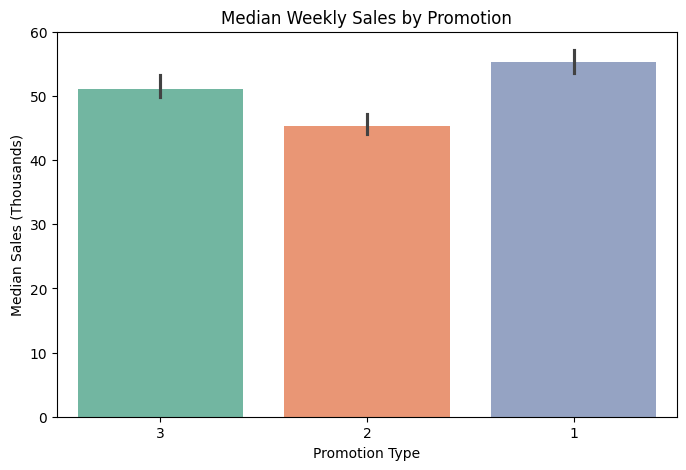

In [ ]:
# Visualization - Median Sales by Promotion
plt.figure(figsize=(8, 5))
sns.barplot(x="promotion",y="salesinthousands",data=marketing_campaign_df, estimator=np.median, palette="Set2")
plt.title("Median Weekly Sales by Promotion")
plt.xlabel("Promotion Type")
plt.ylabel("Median Sales (Thousands)")
plt.show()

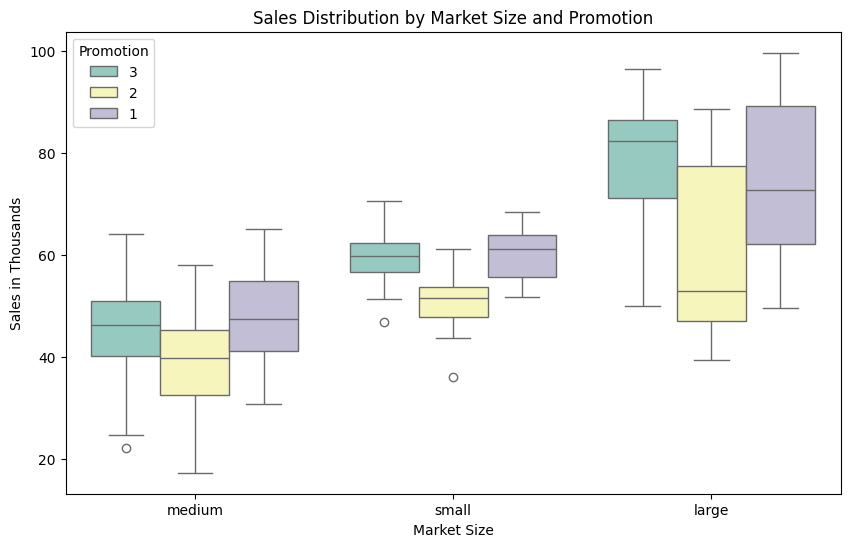

In [40]:
# Subgroup Analysis - Median Sales by Market Size and Promotion
plt.figure(figsize=(10, 6))
sns.boxplot(x="marketsize", y="salesinthousands", hue="promotion", data=marketing_campaign_df, palette="Set3")
plt.title("Sales Distribution by Market Size and Promotion")
plt.xlabel("Market Size")
plt.ylabel("Sales in Thousands")
plt.legend(title="Promotion")
plt.show()

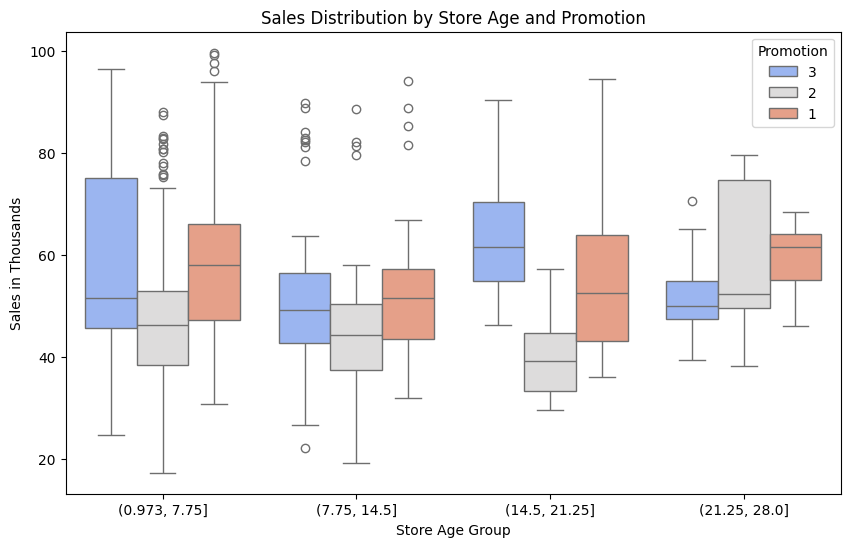

In [41]:
# Subgroup Analysis - Median Sales by Age of Store and Promotion
plt.figure(figsize=(10, 6))
sns.boxplot(x=pd.cut(marketing_campaign_df["ageofstore"], bins=4), y="salesinthousands", hue="promotion", data=marketing_campaign_df, palette="coolwarm")
plt.title("Sales Distribution by Store Age and Promotion")
plt.xlabel("Store Age Group")
plt.ylabel("Sales in Thousands")
plt.legend(title="Promotion")
plt.show()


In [42]:
# Detect outliers in sales column using IQR
Q1 = marketing_campaign_df["salesinthousands"].quantile(0.25)
Q3 = marketing_campaign_df["salesinthousands"].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = (marketing_campaign_df["salesinthousands"] < (Q1 - 1.5 * IQR)) | (marketing_campaign_df["salesinthousands"] > (Q3 + 1.5 * IQR))
outliers = marketing_campaign_df[outlier_condition]
print("\nNumber of Outliers Detected in Sales Column:", len(outliers))


Number of Outliers Detected in Sales Column: 33


C:\Users\smrut\AppData\Local\Temp\ipykernel_21348\4235002140.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="promotion", y="salesinthousands", data=marketing_campaign_df, palette="Set2")


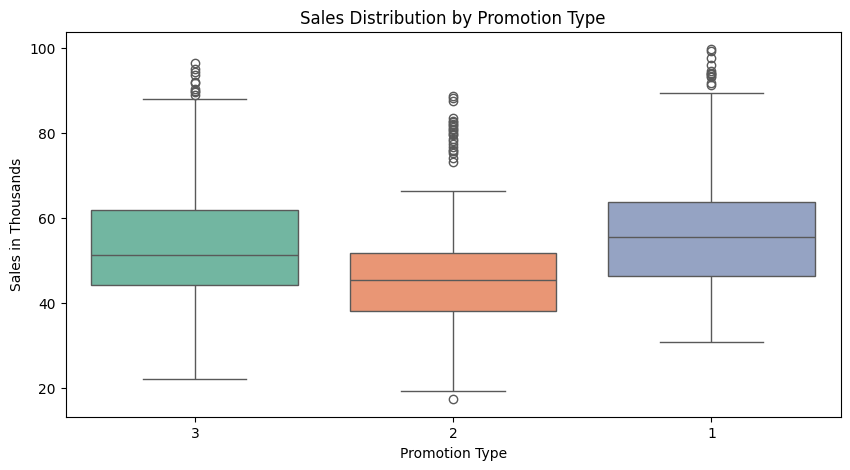

In [ ]:
# Sales distribution per promotion type
plt.figure(figsize=(10, 5))
sns.boxplot(x="promotion", y="salesinthousands", data=marketing_campaign_df, palette="Set2")
plt.title("Sales Distribution by Promotion Type")
plt.xlabel("Promotion Type")
plt.ylabel("Sales in Thousands")
plt.show()

Descriptive Statistics

In [44]:
# Summary statistics of numerical columns
print(marketing_campaign_df.describe())

# Count unique values in categorical columns
print("\nMarket Size Distribution:")
print(marketing_campaign_df['marketsize'].value_counts())
print(marketing_campaign_df['promotion'].value_counts())


       locationid  ageofstore        week  salesinthousands
count  548.000000  548.000000  548.000000        548.000000
mean   479.656934    8.503650    2.500000         53.466204
std    287.973679    6.638345    1.119055         16.755216
min      1.000000    1.000000    1.000000         17.340000
25%    216.000000    4.000000    1.750000         42.545000
50%    504.000000    7.000000    2.500000         50.200000
75%    708.000000   12.000000    3.250000         60.477500
max    920.000000   28.000000    4.000000         99.650000

Market Size Distribution:
marketsize
medium    320
large     168
small      60
Name: count, dtype: int64
promotion
3    188
2    188
1    172
Name: count, dtype: int64


Hypothesis Testing (ANOVA)

In [45]:
import scipy.stats as stats

# Grouping sales by promotion type
sales_groups = [marketing_campaign_df[marketing_campaign_df["promotion"] == p]["salesinthousands"] 
                for p in marketing_campaign_df["promotion"].unique()]

# Perform ANOVA test
anova_result = stats.f_oneway(*sales_groups)

print(f"ANOVA test results: F-statistic={anova_result.statistic}, p-value={anova_result.pvalue}")


ANOVA test results: F-statistic=21.953485793080677, p-value=6.765849261408714e-10


Correlation Analysis

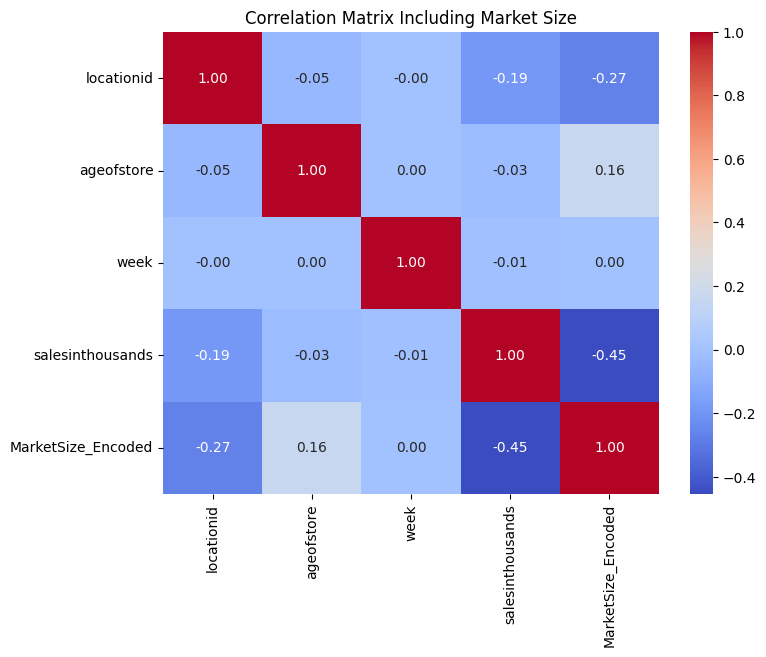

In [46]:
from sklearn.preprocessing import LabelEncoder

# Make a copy of the dataset to avoid modifying the original
temp_df = marketing_campaign_df.copy()

# Encode 'MarketSize' temporarily using Label Encoding
le = LabelEncoder()
temp_df["MarketSize_Encoded"] = le.fit_transform(temp_df["marketsize"])

# Select only numeric columns (including the encoded 'MarketSize')
numeric_df = temp_df.select_dtypes(include=["number"])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Including Market Size")
plt.show()

In [47]:
marketing_campaign_df = pd.get_dummies(marketing_campaign_df, columns=['marketsize'], drop_first=False)
marketing_campaign_df

,locationid,ageofstore,promotion,week,salesinthousands,marketsize_large,marketsize_medium,marketsize_small
MarketID,,,,,,,,
1,1,4,3,1,33.73,False,True,False
1,1,4,3,2,35.67,False,True,False
1,1,4,3,3,29.03,False,True,False
1,1,4,3,4,39.25,False,True,False
1,2,5,2,1,27.81,False,True,False
...,...,...,...,...,...,...,...,...
10,919,2,1,4,64.34,True,False,False
10,920,14,2,1,50.20,True,False,False
10,920,14,2,2,45.75,True,False,False


In [48]:
import statsmodels.formula.api as smf

# Regression Model: Sales ~ Promotion + AgeOfStore + MarketSize dummies
model = smf.ols("salesinthousands ~ promotion + ageofstore + marketsize_medium + marketsize_large+marketsize_small", 
                data=marketing_campaign_df).fit()

# Print summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       salesinthousands   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     150.9
Date:                Tue, 11 Mar 2025   Prob (F-statistic):          3.35e-100
Time:                        17:53:44   Log-Likelihood:                -2082.7
No. Observations:                 548   AIC:                             4177.
Df Residuals:                     542   BIC:                             4203.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             